In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StringType,StructField, IntegerType, DoubleType, TimestampType
import pandas as pd
from pyspark.sql.functions import sum, col, current_timestamp

spark = SparkSession.builder.appName("RetailData").getOrCreate()


data_schema = StructType([
    StructField("InvoiceNo", IntegerType(), True),
    StructField("StockCode", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", TimestampType(), True),
    StructField("UnitPrice", DoubleType(), True),
    StructField("CustomerID", StringType(), True),
    StructField("Country", StringType(), True),
])

In [0]:
# Load the retail data as a stream
streamingData = (
    spark
    .readStream
    .format("csv")
    .schema(data_schema)
    .option("maxFilesPerTrigger", 20)
    .option("header", "true")
    .csv("/FileStore/tables/stream")
)


In [0]:
# Cell 4: Prepare the data
transformed_data = (
    streamingData
    .selectExpr(
        "InvoiceNo",
        "StockCode",
        "Description",
        "cast(Quantity as int) as Quantity",
        "cast(UnitPrice as double) as UnitPrice",
        "cast(CustomerID as int) as CustomerID",  
        "Country"
    )
)


In [0]:

# Cell 5: Capture customer stock aggregates
aggregated_data = (
    transformed_data
    .groupBy("CustomerID")
    .agg(
        sum("Quantity").alias("TotalStocks"),
        sum((col("Quantity") * col("UnitPrice"))).alias("TotalValue")
    )
)

In [0]:
# Cell 6: Start the streaming query and get the results
df = (
    aggregated_data
    .writeStream
    .outputMode("complete")  
    .format("memory") 
    .queryName("aggregated_data")  
    .start()
)


In [0]:
# Cell 7: Display the aggregated data
df = spark.sql("SELECT * FROM aggregated_data")
df.show(truncate=False)

+----------+-----------+-------------------+
|CustomerID|TotalStocks|TotalValue         |
+----------+-----------+-------------------+
|17420     |53         |130.85             |
|14570     |95         |218.05999999999992 |
|17389     |2214       |9447.24            |
|15727     |1203       |2876.0500000000006 |
|16861     |-7         |-22.110000000000003|
|16503     |443        |1082.8899999999999 |
|13285     |914        |1173.2699999999998 |
|15619     |136        |336.40000000000003 |
|13623     |148        |532.0200000000001  |
|14450     |152        |269.45             |
|15790     |114        |220.84999999999997 |
|15447     |85         |155.17             |
|16339     |23         |109.95000000000002 |
|16386     |26         |61.10000000000001  |
|15100     |58         |635.0999999999999  |
|18161     |315        |540.4200000000001  |
|18282     |28         |77.84              |
|16500     |19         |217.74             |
|12471     |4080       |10698.329999999996 |
|14514    

In [0]:
#  Initialize DataFrame to store progress information
progress_data = pd.DataFrame(columns=["TriggerTime", "RecordsImported", "SaleValue"])

In [0]:
#  Define the function process_batch
def process_batch(batch_df, batch_id):
    total_value = batch_df.selectExpr("sum(Quantity * UnitPrice) as TotalValue").collect()[0]["TotalValue"]
    current_time_value = batch_df.select(current_timestamp().cast(TimestampType())).collect()[0][0]
    current_time_python = current_time_value.replace(microsecond=0)  
    progress_df = spark.createDataFrame([(current_time_python, batch_df.count(), total_value)],
                                        ["TriggerTime", "RecordsImported", "SaleValue"])
    progress_df.show(truncate=False)
    
    # Convert the progress_df to pandas and concatenate
    global progress_data
    progress_data = pd.concat([progress_data, progress_df.toPandas()])




In [0]:
# Cell 11: Start the Stream
query = (
    streamingData
    .writeStream
    .outputMode("append")
    .foreachBatch(process_batch)
    .start()
)
query.awaitTermination()


+-------------------+---------------+------------------+
|TriggerTime        |RecordsImported|SaleValue         |
+-------------------+---------------+------------------+
|2023-11-12 09:27:18|61688          |1018540.1600000046|
+-------------------+---------------+------------------+

+-------------------+---------------+-----------------+
|TriggerTime        |RecordsImported|SaleValue        |
+-------------------+---------------+-----------------+
|2023-11-12 09:27:24|32867          |581157.0500000012|
+-------------------+---------------+-----------------+

+-------------------+---------------+-----------------+
|TriggerTime        |RecordsImported|SaleValue        |
+-------------------+---------------+-----------------+
|2023-11-12 09:27:28|27444          |448132.1999999975|
+-------------------+---------------+-----------------+

+-------------------+---------------+------------------+
|TriggerTime        |RecordsImported|SaleValue         |
+-------------------+---------------+-

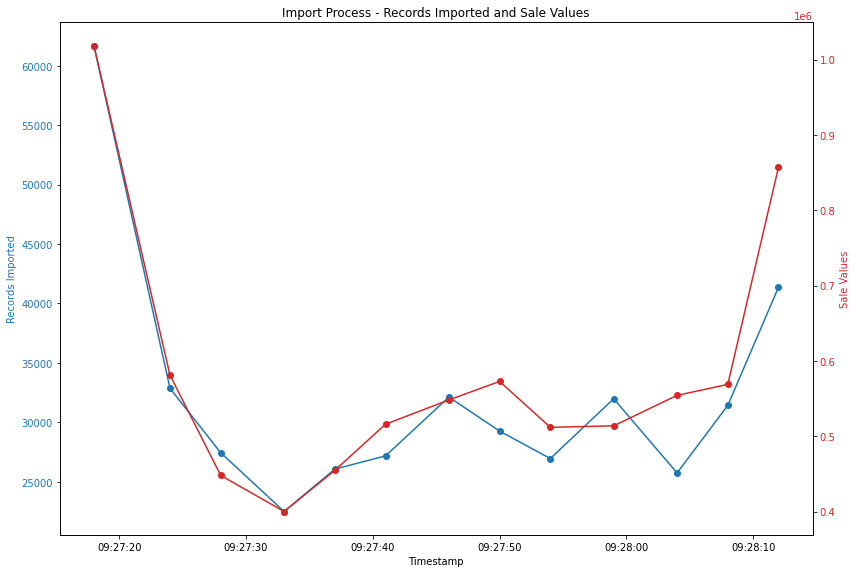

In [0]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 8))
color = 'tab:blue'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Records Imported', color=color)
ax1.plot(progress_data['TriggerTime'], progress_data['RecordsImported'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Sale Values', color=color)
ax2.plot(progress_data['TriggerTime'], progress_data['SaleValue'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('Import Process - Records Imported and Sale Values')
plt.show()